# Data Processing and Analysis : GSM4084997_varying_length_25to100.csv.gz

#### In this notebook, we load the data GSM4084997_varying_length_25to100, preprocess it and analyze it.

#### This data is composed of 106,530 5' UTRs of varying length between 25 and 100 nucleotides, which is significantly less than the previous dataset we explore.

In [3]:
#Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn import preprocessing

## 1. We load the data.

In [13]:
data_path = "Data/GSM4084997_varying_length_25to100.csv.gz"
df = pd.read_csv(data_path, compression='gzip')
df

,Unnamed: 0,utr,set,0,1,2,3,4,5,6,...,r6,r7,r8,r9,r10,r11,r12,total,rl,len
0,0,GTTTTTGGCGCTCCCCTCTTAGCTT,random,128,88,90,97,169,171,130,...,0.115682,0.063186,0.058109,0.071910,0.071695,0.082980,0.064724,0.000557,5.386932,25
1,1,CGCCCCGACTCCCGTTGGCGGGTCT,random,105,78,142,102,164,142,72,...,0.068031,0.045308,0.056234,0.065011,0.090996,0.060355,0.115658,0.000525,5.080745,25
2,2,CTTACGGCCTCTCCAGCCCGCTTGT,random,94,79,97,103,106,142,62,...,0.071915,0.051877,0.061362,0.066953,0.075201,0.057327,0.093283,0.000428,4.995427,25
3,3,TCAGCGGCCATAATGTCCTCCTCTG,random,297,478,293,147,78,48,20,...,0.016034,0.018482,0.027169,0.028505,0.029267,0.035883,0.045036,0.000619,2.779368,25
4,4,GACCCTCCTATTATCAACCAAGATA,random,126,126,104,109,193,245,184,...,0.124887,0.081992,0.068166,0.073027,0.079891,0.068356,0.069435,0.000731,5.552591,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106525,106525,CGGGCCGTTAAATTTCACCCGCATGGATCAGAGAAAATCAACCAAA...,with_uaugs,36,51,47,45,43,42,6,...,0.019778,0.024318,0.055857,0.028921,0.043572,0.044571,0.144244,0.000150,3.990209,50
106526,106526,AACTCTTATGGGGGTTCGTTCAGGCTGGGCACAAGACAAGGAAGTA...,with_uaugs,26,27,22,36,23,15,6,...,0.032308,0.042207,0.035607,0.039784,0.067787,0.050212,0.127366,0.000092,4.199409,50
106527,106527,CCGTGAGTAATGTTCCGCGGGTTCGTGCTCAAAAGTCGTTCAGGTT...,with_uaugs,37,37,73,46,41,37,14,...,0.041091,0.027066,0.052161,0.055569,0.040644,0.035581,0.161412,0.000169,4.137023,50
106528,106528,GCTTGCATTGTTTTGATTGTTCGCGGGCATGTCATGATTCACCTCC...,with_uaugs,24,33,44,45,41,20,8,...,0.029888,0.034452,0.052499,0.031054,0.063494,0.102775,0.108254,0.000133,4.693943,50


## 2. We select the data with sufficient amounts of reads. (higher quality)

#### As in the paper, we will select the first 280 000 values (highest number of reads) which correspond to the higher quality data. 

In [18]:
df = df.sort_values('total_reads', ascending=False)
df = df.reset_index(drop=True)
df['total_reads'].head()

0    4902
1    4506
2    4481
3    4469
4    4464
Name: total_reads, dtype: int64

#### We drop the sequences with low amount of total_reads as they are considered less reliable/qualitative. Here since we don't have a lot of data, we will follow the threshold used in the paper and remove utr's which have less than 10 reads (biologically coherent).

In [19]:
df['Selection'] = "Selected Data"
for i in range(len(df)):
    if ( df['total_reads'][i] <= 10):
        df['Selection'][i] = "Unconsidered Data"

<ipython-input-19-698e72758171>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Selection'][i] = "Unconsidered Data"


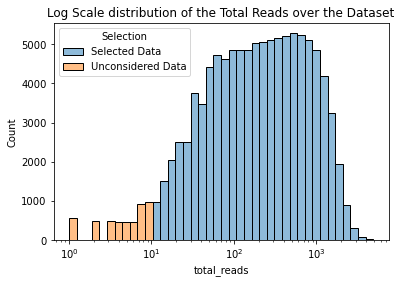

In [20]:
sns.histplot(data=df, x="total_reads", hue = "Selection", bins = 40, log_scale=True)
 
# Show the plot
plt.title("Log Scale distribution of the Total Reads over the Dataset")
plt.show()

In [25]:
df = df[df["Selection"] == "Selected Data"]
#We check that we have selected the data of interest
df["Selection"].unique()

array(['Selected Data'], dtype=object)

## 3. We one-hot encode the sequences and scale the MRL (Mean Ribosome Load).

### We one-hot encode sequences to later use them in models such as CNN, RNN, ...

In [26]:
def one_hot_helper(sequence):
    """
    This function takes in a sequence and returns a one hot encoded list. 
    """
    one_hot_dictionnary = {'A':[1,0,0,0],'C':[0,1,0,0],'G':[0,0,1,0],'T':[0,0,0,1]}
    one_hot_encoded = [one_hot_dictionnary[s] for s in sequence]
    return one_hot_encoded    

In [27]:
df["one-hot encoding"] = df["utr"].apply(one_hot_helper)
df["one-hot encoding"]

0         [[0, 1, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [0,...
1         [[0, 1, 0, 0], [0, 0, 0, 1], [1, 0, 0, 0], [0,...
2         [[0, 1, 0, 0], [0, 1, 0, 0], [1, 0, 0, 0], [0,...
3         [[0, 0, 0, 1], [1, 0, 0, 0], [0, 1, 0, 0], [0,...
4         [[0, 0, 0, 1], [0, 1, 0, 0], [0, 1, 0, 0], [1,...
                                ...                        
101721    [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 1], [1,...
101722    [[0, 0, 0, 1], [0, 1, 0, 0], [0, 1, 0, 0], [0,...
101723    [[0, 1, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0,...
101724    [[0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 1, 0], [0,...
101725    [[0, 0, 1, 0], [0, 1, 0, 0], [0, 1, 0, 0], [1,...
Name: one-hot encoding, Length: 101726, dtype: object

### We scale the mean ribosome load using the z-score.

The Z-score from sklearn.preprocessing standardizes features by removing the mean and scaling to unit variance, which can help in several machine learning models.

In [28]:
df.loc[:,'scaled_rl'] = preprocessing.StandardScaler().fit_transform(df.loc[:,'rl'].values.reshape(-1,1))
df.loc[:,'scaled_rl']

0        -0.743234
1         0.272356
2        -0.855179
3         0.264114
4         0.421665
            ...   
101721    1.666028
101722    1.426246
101723   -0.626288
101724    0.290922
101725   -2.347167
Name: scaled_rl, Length: 101726, dtype: float64

## 4. We save the preprocessed data. 

In [30]:
df.drop('Selection', inplace=True, axis=1)
df.head()

In [34]:
df.to_csv("Data/GSM4084997_varying_length_PREPROCESSED.csv.gz", index=False, compression="gzip")

## 5. We analyze our preprocessed data before starting any basemodels.

In [35]:
df = pd.read_csv("Data/GSM4084997_varying_length_PREPROCESSED.csv.gz", compression='gzip')

### Distribution of the mean ribosome load accross the data

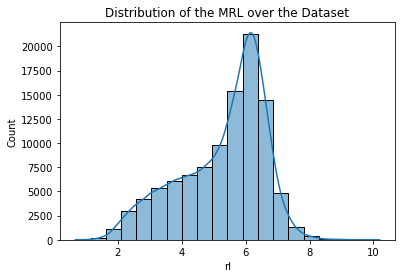

In [36]:
sns.histplot(data=df, x="rl", bins = 20, kde=True)
 
# Show the plot
plt.title("Distribution of the MRL over the Dataset")
plt.show()

The phenomenon of bimodal distribution we observed for the previous dataset is less present in the dataset.

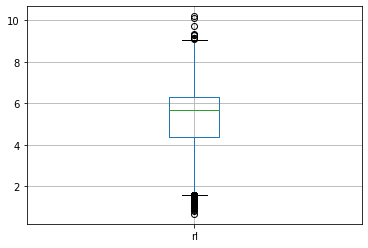

In [37]:
boxplot = df.boxplot(column=["rl"])

In [38]:
df["rl"].describe()

count    101726.000000
mean          5.293059
std           1.335760
min           0.667604
25%           4.398464
50%           5.670986
75%           6.282940
max          10.195283
Name: rl, dtype: float64

We have a mean MRL around 5.3 with a standard deviation of approximately 1.34. 

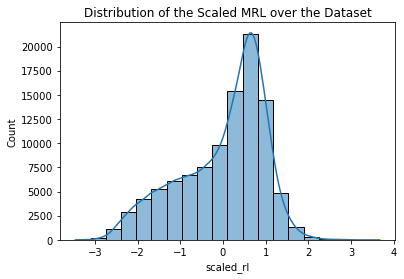

In [39]:
sns.histplot(data=df, x="scaled_rl", bins = 20, kde=True)
 
# Show the plot
plt.title("Distribution of the Scaled MRL over the Dataset")
plt.show()

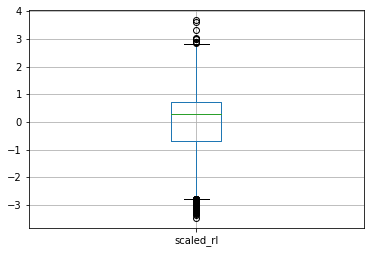

In [40]:
boxplot = df.boxplot(column=["scaled_rl"])

### We know that ATG's in the 5' UTRs play a significant role in expression in function of their positions. 

This phenomenon has been noted trhoughout Litterature as well as in the paper of the Seelig Lab. Let us observe the presence of ATGs vs. the MRL.

In [41]:
df['ATG'] = df['utr'].apply(lambda x: 'ATG' in x)
df['ATG']

0          True
1         False
2          True
3         False
4         False
          ...  
101721    False
101722     True
101723    False
101724     True
101725     True
Name: ATG, Length: 101726, dtype: bool

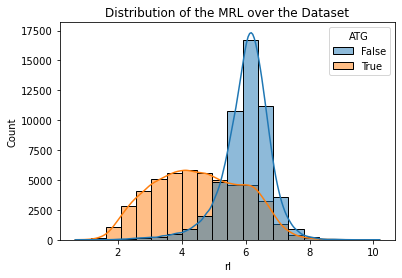

In [42]:
sns.histplot(data=df, x="rl",hue = "ATG", bins = 20, kde=True)
 
# Show the plot
plt.title("Distribution of the MRL over the Dataset")
plt.show()

Once again, we observe a similar phenomenon as in the previous dataset : 5' UTRs without an ATG have generally a higher MRL than 5', concentrated between 4 and 8.